In [84]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import h5py
import sys
sys.path.append('./utilities')
import realDataProcess as rdp
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.morphology import convex_hull_object, opening,closing, disk
import random_forest_v2 as rf
import pandas as pd
import os
from sklearn.utils import shuffle
import seaborn as sns
import labelmask as lm
from glob import glob
from skimage import io
import pickle
from skimage import feature
from skimage import util
import segmentationAnalysis as sega
import freqCutting as fcut
from scipy import fftpack
from skimage import filters
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from scipy.special import erf
from sklearn import metrics
from skimage import morphology


# Morphological Filtering and Get Samples of Empty Regions

In [198]:
maps = h5py.File('Bal_unFilt_CdSeRelabel512Images_20190724_maps.h5')['maps'][:,:,:,:]

In [199]:
images = h5py.File('Bal_MedFilt_CdSeRelabel512Images_20190726.h5')['images'][:,:,:,:]

In [200]:
def get_empties(images,maps):
    empty_squares = []
    empty_maps = []
    for idx,img in enumerate(images):
        points = np.argwhere(maps[idx,:,:,0])
        x1 = points[np.random.random_integers(0,200),1]
        y1 = points[np.random.random_integers(0,200),0]
        x2 = x1 + 100 + np.random.random_integers(0,50)
        y2 = y1 + 100 + np.random.random_integers(0,50)
        square = img[x1:x2,y1:y2,0]
        square_map = maps[idx,x1:x2,y1:y2,0]
        if np.all(square_map) == True:
            empty_squares.append(square)
            empty_maps.append(square_map)
    return empty_squares, empty_maps

In [201]:
test_empty, test_map_empty = get_empties(images,maps)

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead
  
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead
  import sys
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  if __name__ == '__main__':


In [209]:
def postprocess_map(mask):
    """remove rough edges from mask objects using morphological opening, closing and then convex hull object"""
    m = convex_hull_object(closing(opening(mask),selem=disk(5)))
    return m

In [210]:
def postprocess_map_stack(map_stack):
    """Post processes satck of maps"""
    new_maps = np.zeros(map_stack.shape)
    for idx,mask in enumerate(map_stack):
        new_maps[idx] = postprocess_map(mask)
    return new_maps

In [211]:
def box_coordinates(mask, particle_size,max_width,max_height,min_width,min_height,max_r = 0,max_c = 0):
    """find particle regions and return coordinates for particle regions"""
    labels = label(mask)
    particles = []
    for region in regionprops(labels):
        # take regions with large enough areas
        if region.area >= particle_size:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            dif_r = maxr - minr
            dif_c = maxc-minc
            if dif_r < max_height and dif_c < max_width and dif_r > min_height and dif_c > min_width:
        
                if dif_r > max_r:
                    max_r = dif_r
                if dif_c > max_c:
                    max_c = dif_c
                particles.append([minr,maxr,minc,maxc])
            else:
                pass
    return particles, max_r, max_c

In [212]:
def box_cut_images_noPad(image_stack,map_stack, particle_size, max_width,max_height, min_width,min_height, postprocess = False):
    new_stack = []
    max_x = 0
    max_y = 0
    count = 0
    fname = input('enter directory: ')
    if postprocess == True:
        new_maps = postprocess_map_stack(map_stack[:,:,:,1])
    else:
        new_maps = map_stack[:,:,:,1].copy()
    for idx, mask in enumerate(new_maps):
        coords, y, x = box_coordinates(mask, particle_size, max_width,max_height,min_width,min_height, max_y,max_x)
        count += len(coords)
        for c in coords:
            new_stack.append(image_stack[idx][c[0]:c[1],c[2]:c[3]])
    for idx,img in enumerate(new_stack):
        idx = str(idx)
        if len(idx) < 3:
            while len(idx) < 3:
                idx = '0'+idx
        filename = fname +'/particle_' + idx + '.png'
        plt.imsave(filename,img.reshape(img.shape[0],img.shape[1]))
    return new_stack

In [26]:
im_stack3 = box_cut_images_noPad(images,maps,200,250,250,75,75)

enter directory: demo_processing


# Dataset created for Random Forest

In [213]:
def get_images(pathname,label):
    filenames = glob(pathname+'*.png')
    images = []
    labels = []
    for f in filenames:
        images.append(io.imread(f))
        labels.append(label)
    return images, labels

In [311]:
agg_path = '/Users/cgroschner/Documents/RandomForest_labeling/relabeling/agglomeration/'
agg_images, agg_labels = get_images(agg_path,'agglomeration')

In [312]:
empty_path = '/Users/cgroschner/Documents/RandomForest_labeling/relabeling/empty/'
empty_images, empty_labels = get_images(empty_path,'empty')

In [313]:
yes_path = '/Users/cgroschner/Documents/RandomForest_labeling/relabeling/yes/'
yes_images, yes_labels = get_images(yes_path,'yes')

In [314]:
no_path = '/Users/cgroschner/Documents/RandomForest_labeling/relabeling/no/'
no_images, no_labels = get_images(no_path,'no')

In [315]:
nofringe_path = '/Users/cgroschner/Documents/RandomForest_labeling/relabeling/no_fringe/'
nofringe_images, nofringe_labels = get_images(nofringe_path,'nofringe')

In [316]:
print('agg count: ',len(agg_images),'empty count: ',len(empty_images),'yes count: ',len(yes_images),'no count: ',len(no_images),'no fringe count: ',len(nofringe_images))

agg count:  116 empty count:  22 yes count:  150 no count:  161 no fringe count:  143


In [355]:
new_labels = ['empty' for i in np.arange(0,len(test_empty))]

In [356]:
#compile different class images and labels
rf_images = agg_images + no_images + nofringe_images + yes_images + empty_images + test_empty

rf_labels = agg_labels + no_labels + nofringe_labels + yes_labels + empty_labels + new_labels

In [357]:
rf_images_shuf, rf_labels_shuff = shuffle(rf_images,rf_labels,random_state = 0)

# Create Features

In [253]:
def sigmoid(q,qmin,qmax):
    """qmin,qmax are the values at which the sigmoid has --by eye-- arrived at its asymptotes"""
    z = (q - (qmin + (qmax-qmin)/2.)) / (qmax-qmin) * 4
    return (1+erf(z))/2.

def annulus(q,q0,q1,q2,q3):
    return sigmoid(q,q0,q1) - sigmoid(q,q2,q3)

def annular_mask(shape,minr,ring_width,sig_width=20):
    x = shape[0]
    y = shape[1]
    xx, yy = np.meshgrid(np.arange(x),np.arange(y))
    max1 = minr+sig_width
    min2 = max1 + ring_width
    max2 = min2 + sig_width
    rr = np.sqrt((xx-x/2)**2+(yy-y/2)**2)
    mask = annulus(rr,minr,max1,min2,max2)
    return mask

def fft_integrate(image):
    x = np.arange(0,image.shape[0])
    y = np.arange(0,image.shape[1])
    if x.shape[0] < y.shape[0]:
        r = np.sqrt(x**2+x**2)
        cut = image[:,:x.shape[0]]
    elif y.shape[0] < x.shape[0]:
        r = np.sqrt(y**2+y**2)
        cut = image[:y.shape[0],:]
    else:
        r = np.sqrt(x**2+y**2)
        cut = image
    f =fftpack.fft2(cut)
    fft_integrate = np.zeros(r.shape)
    for idx,rad in enumerate(r):
        mask = annular_mask(cut.shape,rad,10,4)
        cut_f = np.abs(fftpack.fftshift(f)*mask)
        fft_integrate[idx] = cut_f.flatten().sum()
    return fft_integrate

In [254]:
def standardize_flattened_feature_size(image_input,size,only_end= False,print_flag=True):
    image = image_input.copy()
    difx = image_input.shape[0] - size
    option = 0
    if only_end == True and difx<0:
        # this option is if you have a feature fecture and you just want to tack zeros on the end
        new_shape = (size,)
        holder = np.zeros(new_shape)
        holder[:image.shape[0]] = image
        image = holder
    elif only_end == True and difx>0:
        image = image[:size]
        option = 0.5
    elif only_end == False and difx > 0:
        midx = difx//2
        oddtest = -difx%2
        if oddtest == 0:
            image = image[midx:-midx]
        elif oddtest == 1:
            image = image[midx:-(midx+1)]
        option =1
    elif only_end == False and difx< 0:
        new_shape = (size,)
        holder = np.zeros(new_shape)
        midx = -difx//2
        holder[midx:midx+image.shape[0]] = image
        image = holder
        option = 2
    if print_flag == True:
        print(option)
    return image

In [255]:
def center_of_mass(fft_int):
    x_vals = np.arange(0,fft_int.shape[0])
    top = np.dot(fft_int,x_vals)
    bottom = fft_int.sum()
    return top/bottom

In [282]:
def gather_img_features(image):
    features = []
    fft_int = fft_integrate(image)[:100]
    features.append(fft_int.mean())
    features.append(fft_int.std())
    features.append(image.mean())
    features.append(image.std())
    com = center_of_mass(fft_int)
    features.append(com)
    return np.array(features)

In [ ]:
gather_img_features

In [330]:
def feature_frame(images,size):
    length = size*size
#     for idx, img in enumerate(images):
#         if img.dtype != 'uint8':
#             images[idx] = img.astype('uint8')
    feta = gather_img_features(images[0])
    feature_labels= [['fft_int_std'],['fft_int_mean'],['image_mean'],['image_std'],['fft_int_com']]
    feature_labels = sum(feature_labels, [])
    features = {'0':feta}
    print(features)
    for idx,img in enumerate(images[1:]):
        feta = gather_img_features(img)
        if np.any(np.isnan(feta)) ==True:
            print(feta, idx, img.shape)
        features[str(idx+1)] = feta
    df = pd.DataFrame.from_dict(features,orient='index')
    df.columns = feature_labels
    return df

In [358]:
df_relabel2 = feature_frame(rf_images_shuf,100)

{'0': array([9.17227218e+05, 1.26994815e+06, 1.06339683e+02, 2.09590835e+01,
       1.38435157e+01])}


In [360]:
df_relabel2['labels'] = rf_labels_shuff

In [361]:
df_relabel2.head()

,fft_int_std,fft_int_mean,image_mean,image_std,fft_int_com,labels
0,9.172272e+05,1.269948e+06,106.339683,20.959084,13.843516,empty
1,6.195358e+05,8.591957e+05,108.463824,20.612072,11.792349,nofringe
2,2.074968e+06,2.361819e+06,106.778346,21.010064,19.260867,agglomeration
3,7.944570e+05,1.101360e+06,105.083205,23.412287,12.412479,yes
4,1.078469e+06,1.458061e+06,96.785651,20.886708,15.477466,agglomeration


# Train, Val, Test Split

In [381]:
df_relabel2['labels'].value_counts()

no               161
yes              150
nofringe         143
agglomeration    116
empty             97
Name: labels, dtype: int64

In [362]:
def split_set_v2(df,labels,fraction,include_last=True):
    """splits training and testing dataframes into feature and label sets"""
    idx = int(df.shape[0]*fraction)
    total = idx*2
    idx_train = df.shape[0]-total
    if include_last == False:
        X_train = df.iloc[:idx_train,:-1]
        X_test = df.iloc[idx_train:idx_train+idx,:-1]
        X_val = df.iloc[idx_train+idx:,:-1]
    else:
        X_train = df.iloc[:idx_train,:]
        X_test = df.iloc[idx_train:idx_train+idx,:]
        X_val = df.iloc[idx_train+idx:,:]
    Y_train = labels[:idx_train]
    Y_test = labels[idx_train:idx_train+idx]
    Y_val = labels[idx_train+idx:]
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [363]:
X_train_redo, Y_train_redo, X_test_redo, Y_test_redo, X_val_redo, Y_val_redo = split_set_v2(df_relabel2.iloc[:,:-1],df_relabel2['labels'],0.25)

In [ ]:
X_train_relabel2.to_csv('20200310_X_train_relabel2.csv')
Y_train_relabel2.to_csv('20200310_Y_train_relabel2.csv')
X_test_relabel2.to_csv('20200310_X_test_relabel2.csv')
Y_test_relabel2.to_csv('20200310_Y_test_relabel2.csv')
X_val_relabel2.to_csv('20200310_X_val_relabel2.csv')
Y_val_relabel2.to_csv('20200310_Y_val_relabel2.csv')

# Train and Validate Random Forest

In [47]:
X_test_relabel2=pd.read_csv('20200310_X_test_relabel2.csv')
Y_test_relabel2=pd.read_csv('20200310_Y_test_relabel2.csv',index_col=0,names=['data'])
X_val_relabel2=pd.read_csv('20200310_X_val_relabel2.csv')
Y_val_relabel2=pd.read_csv('20200310_Y_val_relabel2.csv',index_col=0,names=['data'])
X_train_relabel2=pd.read_csv('20200310_X_train_relabel2.csv')
Y_train_relabel2=pd.read_csv('20200310_Y_train_relabel2.csv',index_col=0,names=['data'])

In [365]:
def train_random_forest2(X_train, Y_train, nestimators = 50,crit='gini',max_feat='auto'):
    """function that takes in the training feature set and training labels and trains a radnom forest with 
    n estimators given by nestimators"""
    classifier = RandomForestClassifier(n_estimators= nestimators,criterion= crit,max_features=max_feat,oob_score=True)
    classifier.fit(X_train, Y_train)
    return classifier

In [366]:
model_redo = train_random_forest2(X_train_redo,Y_train_redo,nestimators=500)

In [386]:
pickle.dump(model_redo,open('final_randomforest_24042020.pkl','wb'))

In [367]:
model_redo.oob_score_

0.8507462686567164

In [69]:
#load original model
model3 = pickle.load(open('final_randomforest.pkl','rb'))

In [368]:
# take classes imbalance into account
def class_weights(Y_true):
    agg_count = 0
    empty_count = 0
    no_count = 0
    nofringe_count = 0
    yes_count = 0
    for i in Y_true:
        if i == 'agglomeration':
            agg_count +=1
        elif i == 'empty':
            empty_count +=1
        elif i == 'no':
            no_count +=1
        elif i == 'nofringe':
            nofringe_count +=1
        elif i == 'yes':
            yes_count +=1
    weights = np.array([agg_count/len(Y_true),empty_count/len(Y_true),no_count/len(Y_true),nofringe_count/len(Y_true),yes_count/len(Y_true)])
    samp_weights = np.zeros(len(Y_true))
    for idx,i in enumerate(Y_true):
        if i == 'agglomeration':
            samp_weights[idx] = weights[0]
        elif i == 'empty':
            samp_weights[idx] = weights[1]
        elif i == 'no':
            samp_weights[idx] = weights[2]
        elif i == 'nofringe':
            samp_weights[idx] = weights[3]
        elif i == 'yes':
            samp_weights[idx] = weights[4] 
    return weights, samp_weights

In [369]:
weights, samp_weights = class_weights(Y_val_redo)

model_redo.score(X_val_redo,Y_val_redo,samp_weights)

0.8639272482317281

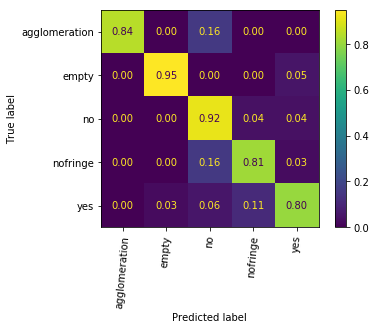

In [371]:
metrics.plot_confusion_matrix(model_redo,X_val_redo,Y_val_redo,normalize='true',xticks_rotation=85,values_format='0.2f')